In [48]:
import pickle
import warnings

import arviz as az
import colormaps as cmaps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cmcrameri import cm
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

warnings.filterwarnings("ignore", category=FutureWarning)

import collections.abc

collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

from causalgraphicalmodels import CausalGraphicalModel

# Ignore future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Data

In [49]:
# load the raw data
df = pd.read_csv(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\combined_data.csv",
    index_col=0,
)

df["doctype_bin"] = df["doctype"].replace({"Book": 1, "Article": 0})

# make ordinal values 0 - 4 for the models
df["ordinal"] = df["ordinal"] - 1

# chauvinism model trace
trace_chauv_thurstonian_all = az.from_netcdf(
    r"C:\Users\conix\Documents\IIH_localtraces\\trace_chauvinism_thurstonian_all_FINAL.nc"
)

# effect size data
# see effect sizes notebook for how these were generated

with open(r"C:\Users\conix\Documents\IIH_localtraces\df_ppc.pkl", "rb") as file:
    # Use pickle.load to deserialize the dictionary
    df_es = pickle.load(file)

es_papers = df_es["es_papers"].values
es_raters = df_es["es_raters"].values
es_field = df_es["es_field"].values
es_content = df_es["es_content"].values

with open(r"C:\Users\conix\Documents\IIH_localtraces\book_es.pkl", "rb") as file:
    # Use pickle.load to deserialize the dictionary
    book_es = pickle.load(file)


# proportions of relevant papers with and without chauvinism

with open(r"C:\Users\conix\Documents\IIH_localtraces\chauv_props.pkl", "rb") as file:
    # Use pickle.load to deserialize the dictionary
    chauv_props = pickle.load(file)

with open(r"C:\Users\conix\Documents\IIH_localtraces\nochauv_props.pkl", "rb") as file:
    # Use pickle.load to deserialize the dictionary
    nochauv_props = pickle.load(file)

# proportions of relevant documents for the various content categories

with open(r"C:\Users\conix\Documents\IIH_localtraces\contents_array.pkl", "rb") as file:
    # Use pickle.load to deserialize the dictionary
    contents_array = pickle.load(file)

# proportions of relevant documents for the various fields

with open(r"C:\Users\conix\Documents\IIH_localtraces\fields_array.pkl", "rb") as file:
    # Use pickle.load to deserialize the dictionary
    fields_array = pickle.load(file)

# Colours

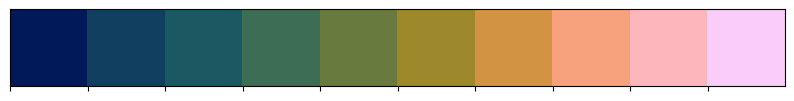

In [50]:
# colormap we use from https://github.com/callumrollo/cmcrameri
cmap = cm.batlow

# Convert the colormap to a seaborn palette with a specified number of colors
num_colors = 10  # Number of discrete colors in the palette
palette = sns.color_palette(cmap(np.linspace(0, 1, num_colors)))
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]

sns.palplot(palette)  # Visualize the selected palette
plt.show()

# isolate one color for rater properties, and one for document properties

rater_color = colors[7]
document_color = colors[3]

# in hex for DAG


def rgba_to_hex(rgba):
    return "#{:02x}{:02x}{:02x}".format(
        int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)
    )


rater_color_hex = rgba_to_hex(rater_color)
document_color_hex = rgba_to_hex(document_color)
outcome_color_hex = rgba_to_hex(colors[-1])
unobserved = "lightgrey"

In [51]:
# Different colormap for the raw rater scores figure
cmap = cm.lajolla

# Convert the colormap to a seaborn palette with a specified number of colors
num_colors = 20  # Number of discrete colors in the palette
palette = sns.color_palette(cmap(np.linspace(0, 1, num_colors)))

# Select the 4th, 5th, and 2nd colors from the palette (indexing starts at 0)
rr_selected_colors = [palette[9], palette[5], palette[14], palette[16]]

# Create a new seaborn palette from the selected colors
rr_palette = sns.color_palette(rr_selected_colors)
rr_palette

[(0.82494, 0.343407, 0.299513),
 (0.424448, 0.210766, 0.174453),
 (0.924416, 0.662121, 0.327392),
 (0.955147, 0.802494, 0.382156)]

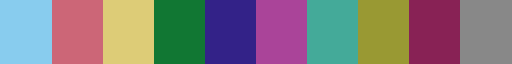

In [52]:
# different colors for the categorical plot (topic by field)

cat_colors = [cmaps.safe(i / (10 - 1)) for i in range(10)]
# add white for whitespace
cat_colors.append((1.0, 1.0, 1.0, 1.0))
cmaps.safe.discrete(10)

# Figure 1: DAG

In [53]:
# write down all nodes and edges


topic_codes = ["Topic"]
outcome_vars = ["Binary", "Rank"]
rater_props = ["Chauvinism", "GWH", "Rater field", "Strictness", "Seniority"]
abstract_props = ["Abstract value", "Field"]
interactions = [
    "Topic/Field",
    "Topic/GWH",
]
other = ["Value estimate"]  # Altmetrics removed for now

topic_edges = [("Topic", "Abstract value"), ("Field", "Topic")]
estimate_edges = [
    (i, "Value estimate")
    for i in ["Abstract value", "Chauvinism", "Topic/Field", "Topic/GWH"]
]

interaction_edges = [
    ("Rater field", "Topic/Field"),
    ("Topic", "Topic/Field"),
    ("Topic", "Topic/GWH"),
    ("GWH", "Topic/GWH"),
]
other_edges = [
    ("Value estimate", "Binary"),
    ("Strictness", "Binary"),
    ("Value estimate", "Rank"),
    ("Field", "Chauvinism"),
    ("Rater field", "Chauvinism"),
    ("Rater field", "GWH"),
    ("Field", "Abstract value"),
    ("Seniority", "Value estimate"),
    ("Seniority", "GWH"),
]

altmetric_edges = [
    ("Abstract value", "Altmetrics"),
    ("Topic", "Altmetrics"),
    ("Field", "Altmetrics"),
]

nodes = (
    topic_codes
    + outcome_vars
    + rater_props
    + abstract_props
    + interactions
    + other
    + ["Document type"]
)
edges = (
    topic_edges
    + estimate_edges
    + other_edges
    + interaction_edges
    + [
        ("Document type", "Topic"),
        ("Document type", "Abstract value"),
    ]  # + altmetric_edges removed
)

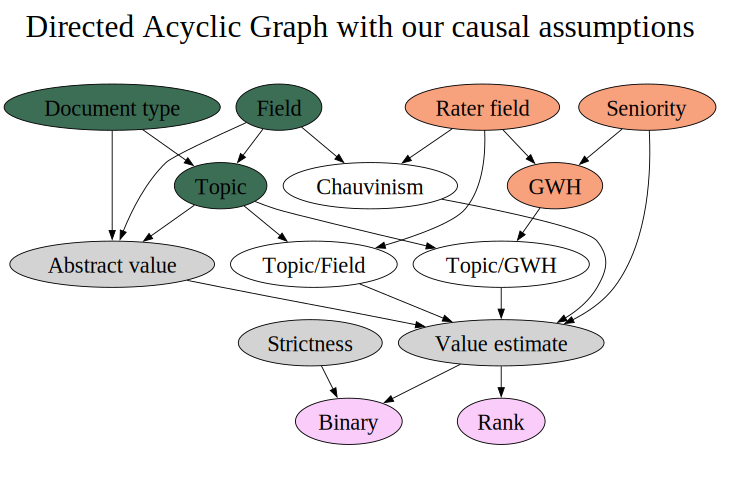

In [54]:
shortDag = CausalGraphicalModel(nodes=nodes, edges=edges)


color_map = {
    "Binary": outcome_color_hex,
    "Rank": outcome_color_hex,
    "Value estimate": unobserved,
    "Abstract value": unobserved,
    "Strictness": unobserved,
    "Field": document_color_hex,
    "Topic": document_color_hex,
    "GWH": rater_color_hex,
    "Rater field": rater_color_hex,
    "Seniority": rater_color_hex,
    "Document type": document_color_hex,
    "Chauvinism": "white",
    "Topic/Field": "white",
    "Topic/GWH": "white",
}

# adapted draw such that it includes colors
dag_figure = shortDag.draw2(color_map=color_map)
dag_figure.graph_attr.update(size="10,10")
dag_figure.graph_attr.update(
    label="Directed Acyclic Graph with our causal assumptions\n\n",
    fontsize="35",
    labelloc="t",
    margin="0.5,0.5",
)
node_fontsize = 25  # Adjust the font size as needed

for node in color_map.keys():
    dag_figure.node(
        node,
        _attributes={
            "fontsize": str(node_fontsize),
            "fillcolor": color_map[node],
            "style": "filled",
        },
    )

output_file = r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\DAG"
dag_figure.render(filename=output_file, format="tiff", cleanup=True)
dag_figure

# Figure 2: Raw rater scores

In [55]:
# prepare data to make a figure with all the raw rater scores
# we want both ranks and binary scores, for chauvinism and non-chauvinism
# we want to separate them by groups

# get the rank scores, and change the scale to 0 - 1 for visualization along with proportions
df["ranks_rescaled"] = df["ordinal"].replace({0: 0, 1: 0.25, 2: 0.5, 3: 0.75, 4: 1})

# get the proportion of relevant papers by rater
overall_means = df.groupby("rater")["binary"].mean()

# get the proportions for chauvinist humanities raters, and for non-humanities raters
chauv_means = (
    df.loc[(df.chauvinism == 1) | (df.field_group != "Humanities")]
    .groupby("rater")[["binary", "ranks_rescaled"]]
    .mean()
    .reset_index()
)

# combine into one df
# for non-humanities, the chauvinism data are just the same as the non-chauvinism ones
chauv_means["overall_means"] = overall_means.values
# rename columns for clarity
chauv_means.columns = ["rater", "binary_chauv", "rank_chauv", "binary_all"]

# for each rater, add the group they were part of
rater_groups = df[["rater", "group"]].drop_duplicates().set_index("rater").to_dict()
chauv_means["group"] = chauv_means["rater"].replace(rater_groups["group"])
chauv_means["group"] = chauv_means["group"].replace({"main": "group3 (Hum)"})

# sort by group so they are together
chauv_means = chauv_means.sort_values(by=["group", "rater"])

# make categorical
chauv_means["group"] = pd.Categorical(
    chauv_means["group"],
    categories=["group1", "group2", "group3 (Hum)", "group3 (Other)"],
    ordered=True,
)

# identify all raters that were non-humanities
non_hum_raters = df.loc[df.field_group != "Humanities"]["rater"].unique()

# the non-hum raters have no chauvinism scores (it would always be 0.5)
chauv_means.loc[chauv_means.rater.isin(non_hum_raters), "rank_chauv"] = np.nan
chauv_means.loc[chauv_means.rater.isin(non_hum_raters), "binary_chauv"] = np.nan

# Change the group of the non-hum raters, so we can visualize them separately
chauv_means.loc[chauv_means.rater.isin(non_hum_raters), "group"] = "group3 (Other)"

chauv_means.tail()

,rater,binary_chauv,rank_chauv,binary_all,group
22,222_main,NaN,NaN,0.353333,group3 (Other)
23,223_main,NaN,NaN,0.800000,group3 (Other)
24,224_main,NaN,NaN,0.226667,group3 (Other)
25,225_main,NaN,NaN,0.226667,group3 (Other)
26,226_main,NaN,NaN,0.420000,group3 (Other)


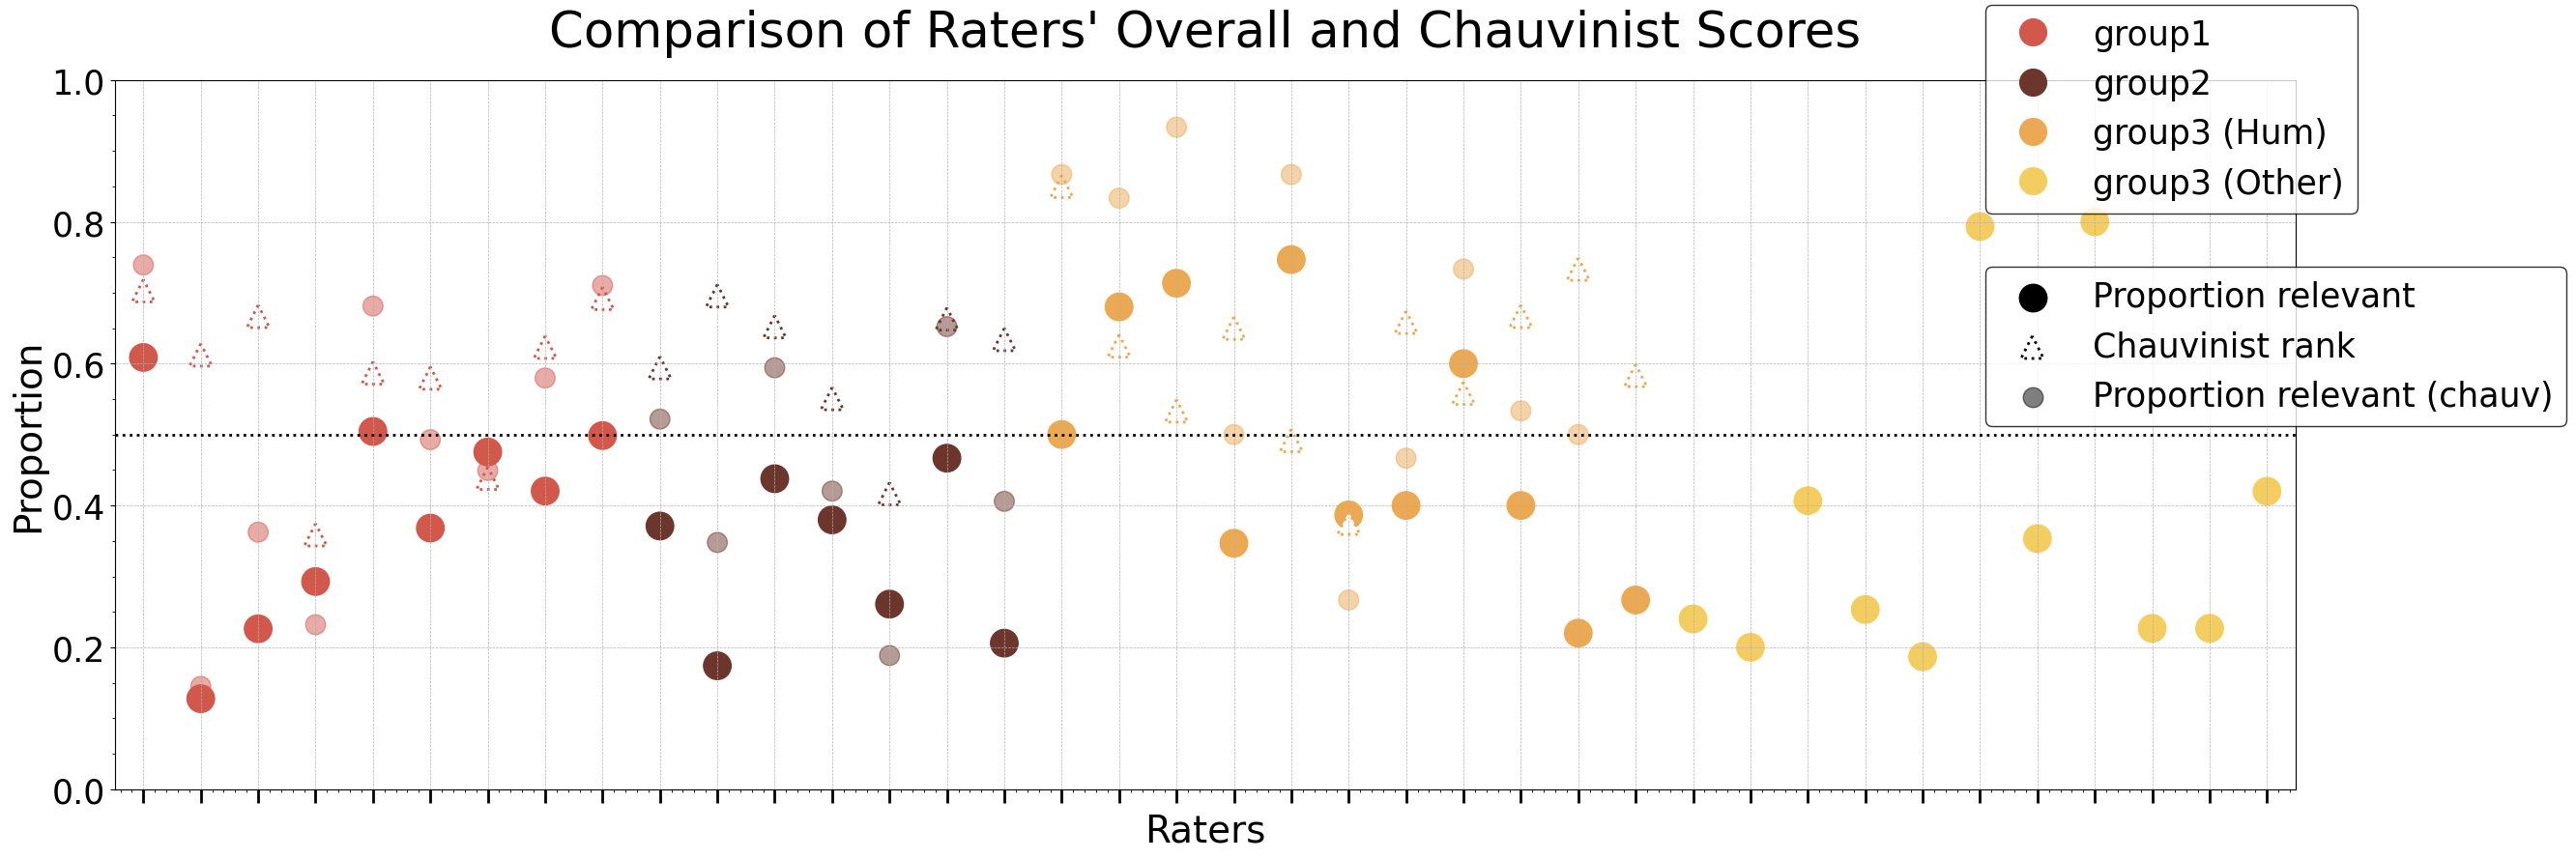

In [56]:
# Now plot these data

# Font size variables
title_fontsize = 37
label_fontsize = 28
legend_fontsize = 25
ticks_fontsize = 25

# convert 'group' column to string for mapping
chauv_means["group"] = chauv_means["group"].astype(str)

# Sort by group and then by rater to position groups together
chauv_means = chauv_means.sort_values(by=["group", "rater"]).reset_index(drop=True)


plt.figure(figsize=(27, 9))

# assign color to each group
group_color_map = {
    group: rr_palette[i]
    for i, group in enumerate(sorted(chauv_means["group"].unique()))
}
# map the colors for plotting
colors = chauv_means["group"].map(group_color_map)

# Plot the overall_means, rank_chauv, and binary_chauv for each rater
scatter1 = plt.scatter(
    chauv_means.index,
    chauv_means["binary_all"],
    s=420,
    color=colors,
    marker="o",
    alpha=1,
    label="Overall Means",
)
scatter2 = plt.scatter(
    chauv_means.index,
    chauv_means["rank_chauv"],
    s=280,
    edgecolors=colors,
    facecolors="white",
    linestyle=":",
    marker="^",
    linewidths=2,
    alpha=1,
    label="Rank (Rescaled)",
)
scatter3 = plt.scatter(
    chauv_means.index,
    chauv_means["binary_chauv"],
    s=220,
    color=colors,
    marker="o",
    alpha=0.5,
    label="Binary",
)

# Customize the plot
plt.ylim(0, 1)
plt.yticks(fontsize=ticks_fontsize)
plt.xlabel("Raters", fontsize=label_fontsize)
plt.ylabel("Proportion", fontsize=label_fontsize)
plt.title(
    "Comparison of Raters' Overall and Chauvinist Scores",
    fontsize=title_fontsize,
    pad=25,
)
plt.xlim(-0.5, len(chauv_means) - 0.5)

# ticks
plt.minorticks_on()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(ticks=range(len(chauv_means)), labels=[])
plt.tick_params(
    axis="x", length=10, width=2
)  # Apply the same size to both major and minor ticks

# line to show mean rank
plt.axhline(0.5, linestyle=":", lw=2, color="black")


## legends

# Create custom legend for the groups
group_handles = [
    plt.Line2D(
        [0], [0], marker="o", color=color, linestyle="", markersize=20, label=group
    )
    for group, color in group_color_map.items()
]
legend1 = plt.legend(
    handles=group_handles,
    title=None,
    loc="upper left",
    bbox_to_anchor=(0.85, 1.13),
    fontsize=legend_fontsize,
)

# Add the group legend to the plot
plt.gca().add_artist(legend1)

# Create legend for markers (shapes only)
legend2 = plt.legend(
    [scatter1, scatter2, scatter3],
    ["Proportion relevant", "Chauvinist rank", "Proportion relevant (chauv)"],
    loc="upper left",
    bbox_to_anchor=(0.85, 0.76),
    fontsize=legend_fontsize,
)

# Set the color of the markers legend to black
# this way we don't need a separate marker legend for each group
for i, handle in enumerate(legend2.legend_handles):
    handle.set_color("black")  # Set the edge color to black for all handles
    if i == 1:  # Check if it's the second handle (index 1)
        handle.set_facecolor("none")  # Remove fill color
        handle.set_edgecolor("black")  # Set the edge color to black

# make legend frames edge black
legend1.get_frame().set_edgecolor("black")
legend2.get_frame().set_edgecolor("black")

# Save the figure
plt.tight_layout()
plt.savefig(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\IRR_descriptive_absolute.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

# Figure 3: Rater vs Abstract characteristics

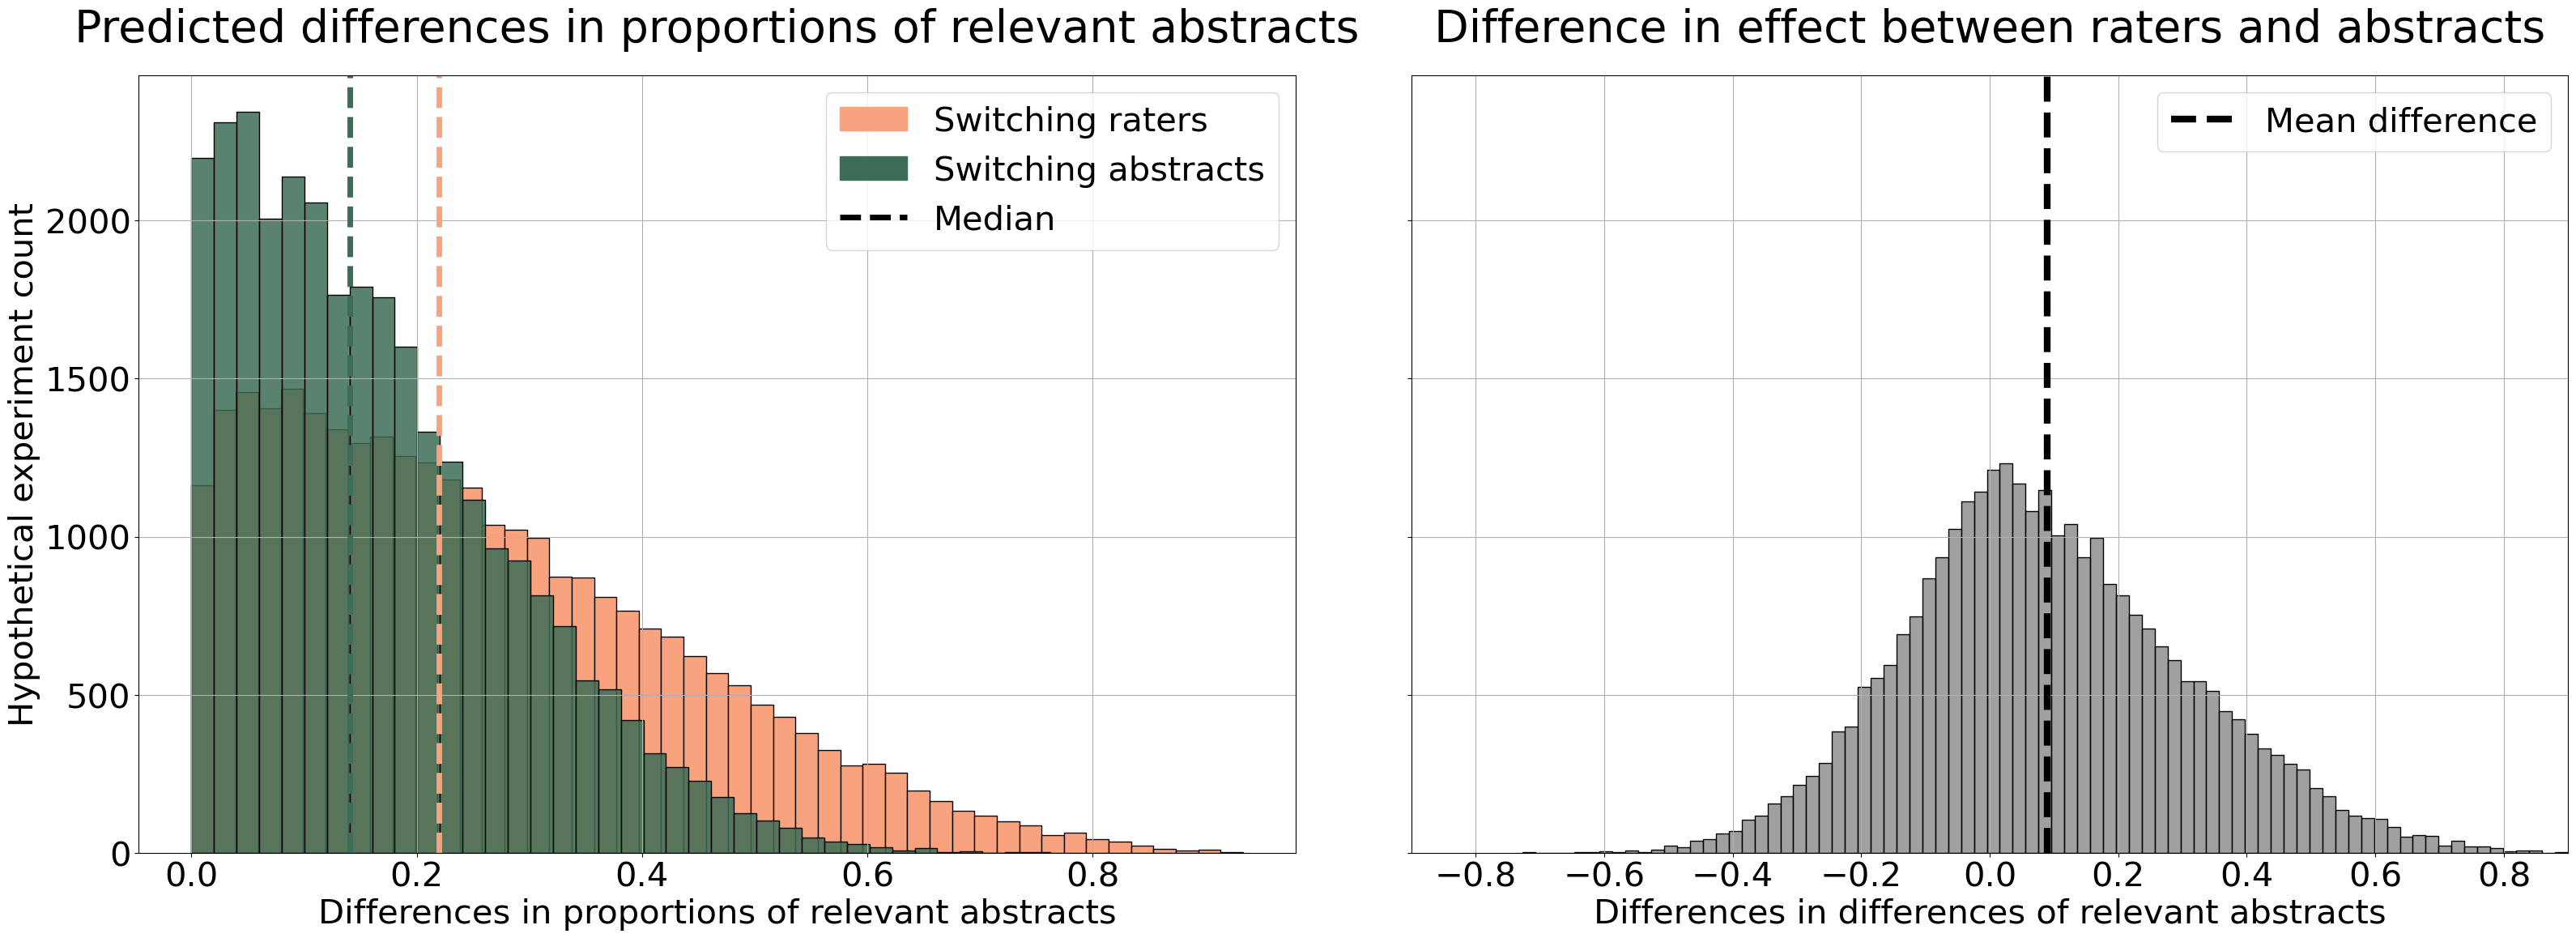

In [57]:
# make a figure to compare the effect of rater and abstract characteristics

# use the same binning method and sizes for all figures
title_fs = 40
label_fs = 30
binning_method = "doane"  # should be good for skewed distributions
bin_width = 0.02

fig, ax = plt.subplots(ncols=2, figsize=(40, 12), sharey=True)


# histogram of rater property effect size
sns.histplot(
    df_es.es_raters,
    color=rater_color,
    ax=ax[0],
    alpha=1,
    binwidth=bin_width,
    bins=binning_method,
)
# histogram of document property effect size
sns.histplot(
    df_es.es_papers,
    color=document_color,
    ax=ax[0],
    alpha=0.85,
    binwidth=bin_width,
    bins=binning_method,
)
# add the medians (mean not so interesting with this skew)
# twice in order to have a black edge

ax[0].axvline(np.median(es_papers), ls="--", lw=5, color=document_color, alpha=1)


ax[0].axvline(np.median(es_raters), ls="--", lw=5, color=rater_color, alpha=1)


# Create the legend for the left plot
legend_handles = [
    Patch(color=rater_color, label="Switching raters"),
    Patch(color=document_color, label="Switching abstracts"),
    Line2D([0], [0], color="black", lw=5, linestyle="--", label="Median"),
]

ax[0].legend(handles=legend_handles, fontsize=label_fs)

# plot the difference in effect sizes on the right by subtracting them
sns.histplot(
    df_es.es_raters - df_es.es_papers,
    color="grey",
    ax=ax[1],
    binwidth=bin_width,
    bins=binning_method,
)
# add the mean of the differences (and legend) to show that it is positive
ax[1].axvline((df_es.es_raters - df_es.es_papers).mean(), color="black", ls="--", lw=6)
ax[1].legend(["Mean difference"], fontsize=label_fs)

# add titles to both plots
ax[0].set_title(
    "Predicted differences in proportions of relevant abstracts",
    fontsize=title_fs,
    pad=30,
)
ax[1].set_title(
    "Difference in effect between raters and abstracts", fontsize=title_fs, pad=30
)

# set grids, the axis labels, limits and ticks of both plots
ax[0].set_ylabel("Hypothetical experiment count", fontsize=label_fs)
ax[0].set_xlabel("Differences in proportions of relevant abstracts", fontsize=label_fs)
ax[1].set_xlabel("Differences in differences of relevant abstracts", fontsize=label_fs)
ax[1].set_xlim([-0.9, 0.9])
ax[0].tick_params(axis="both", which="major", labelsize=label_fs)
ax[1].tick_params(axis="both", which="major", labelsize=label_fs)
ax[0].grid(True, which="major")
ax[1].grid(True, which="major")

# save and show
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.3)
fig.savefig(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\docrater_effectsizes.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

# Figure 4: Relevance estimate

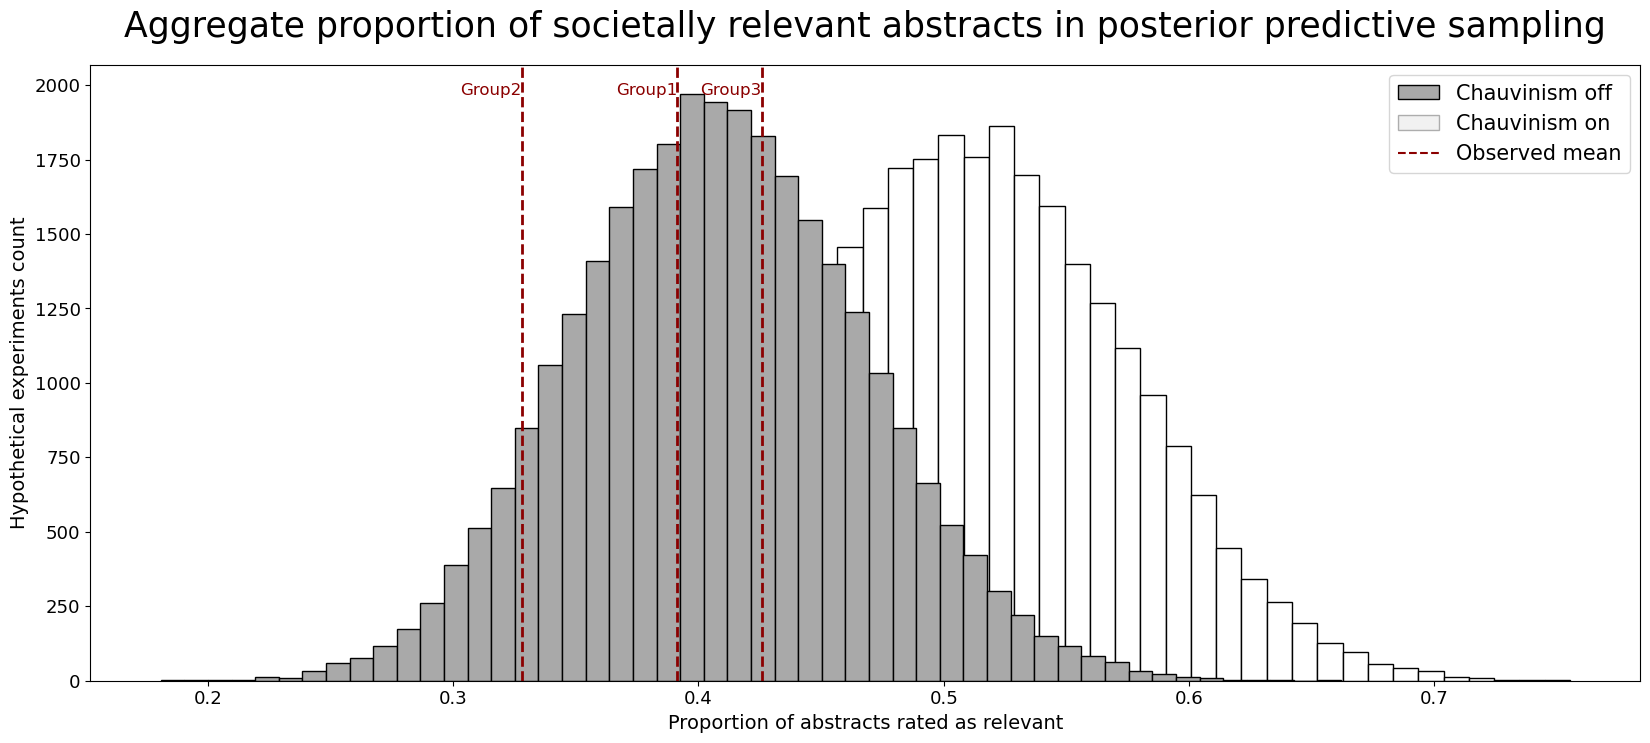

In [66]:
# now plot the expected proportion of relevant documents
# this is if we run our experiment many times

fig, ax = plt.subplots(figsize=(20, 8))

# plot the proportions with chauvinism
hist2 = sns.histplot(
    chauv_props, bins=50, color="white", edgecolor="black", alpha=1, ax=ax
)

# proportions without chauvinism
hist1 = (
    sns.histplot(
        nochauv_props, bins=50, color="darkgrey", alpha=1, edgecolor="black", ax=ax
    ),
)

# plot the mean for each group
# and annotate the line
for j, i in enumerate(["group1", "group2", "main"]):
    mean = df.loc[df.group == i]["binary"].mean()
    ax.axvline(mean, color="darkred", lw=2, ls="--")
    ax.annotate(
        f"Group{j+1}",
        xy=(mean, ax.get_ylim()[1]),
        xytext=(mean - 0.025, ax.get_ylim()[1] - 100),
        ha="left",
        fontsize=12,
        color="darkred",
    )


# Legend
legend_elements = [
    Patch(facecolor="darkgrey", edgecolor="black", label="Chauvinism off"),
    Patch(facecolor="lightgrey", edgecolor="black", label="Chauvinism on", alpha=0.3),
    Line2D([0], [0], color="darkred", label="Observed mean", alpha=1, linestyle="--"),
]
ax.legend(handles=legend_elements, facecolor="white", fontsize=15)


# set title, labels and ticks
ax.set_title(
    "Aggregate proportion of societally relevant abstracts in posterior predictive sampling",
    fontsize=25,
    pad=20,
)
ax.set_ylabel("Hypothetical experiments count", fontsize=14)
ax.set_xlabel("Proportion of abstracts rated as relevant", fontsize=14)
ax.tick_params(axis="x", labelsize=13)  # Change font size of x-axis tick labels
ax.tick_params(axis="y", labelsize=13)  # Change font size of x-axis tick labels

# save and show
fig.savefig(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\overall_estimate.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Figure 5: Relevance by field and content codes

In [59]:
content_codes = [
    "fiction",
    "present",
    "empirical",
    "intolerance",
    "ethics",
    "environment",
    "education",
    "wellbeing",
    "deliverable",
]

labels = [
    "No code",
    "Real-world",
    "Present",
    "Empirical",
    "Discrimination",
    "Ethics",
    "Environment",
    "Education",
    "Wellbeing",
    "Output",
]

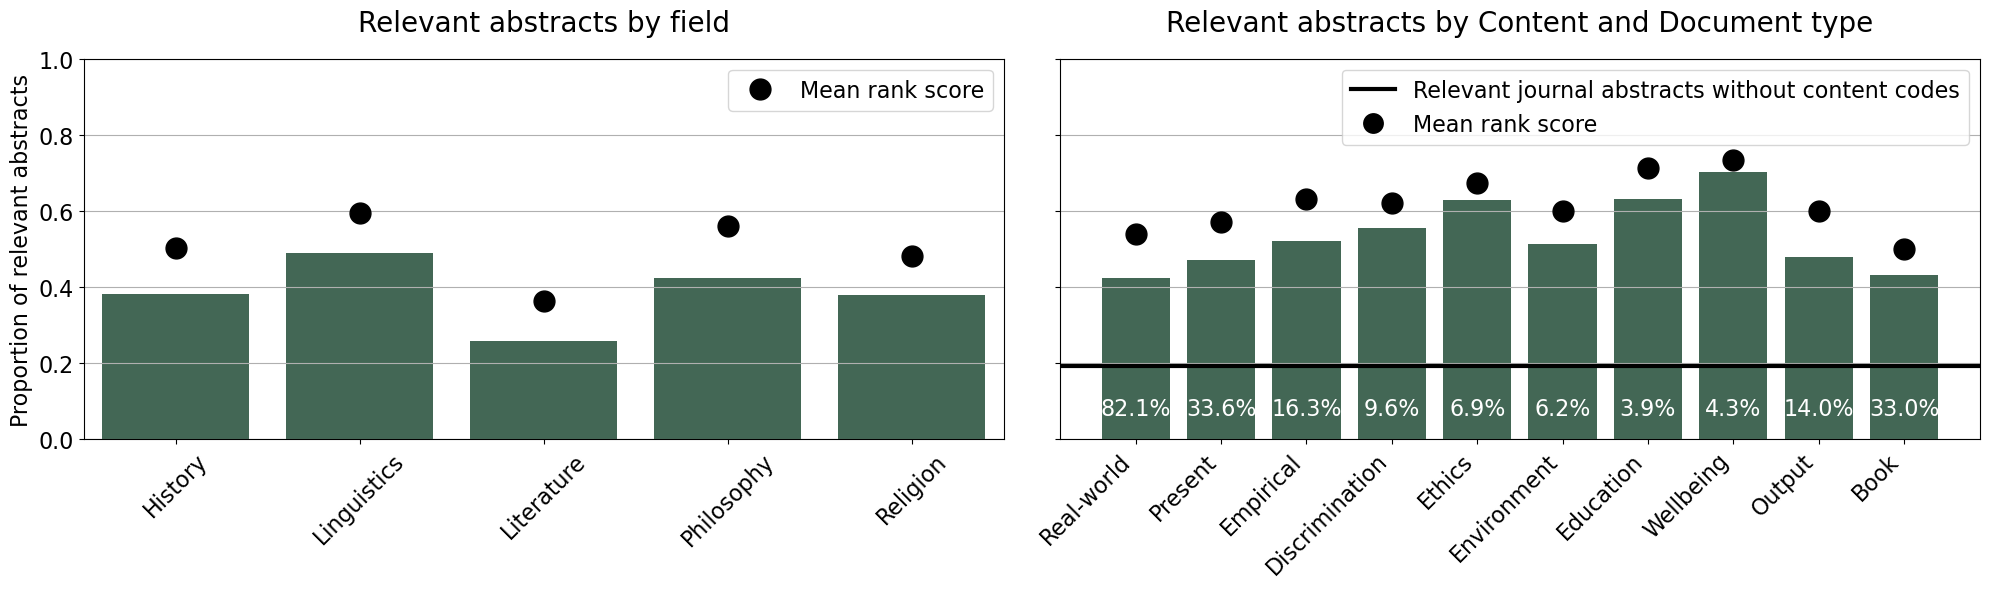

In [60]:
# Plot the frequency of relevant docs by field and topic

# # Define font size variables
title_fs = 20
label_fs = 16
tick_fs = 16
marker_fs = 15


fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(20, 6))


# plot 1 (left): the field plot

# get the data
field_ranks = df.groupby("field")["ranks_rescaled"].mean()

# plot the mean rank with a marker
for index, value in enumerate(list(field_ranks)):
    ax[0].plot(index, value, "ko", markersize=marker_fs)


# plot proportion of relevant documents by field
sns.barplot(df.groupby("field")["binary"].mean(), ax=ax[0], color=document_color)
ax[0].set_title("Relevant abstracts by field", fontsize=title_fs, pad=20)
ax[0].tick_params(axis="x", labelsize=tick_fs, rotation=45)
ax[0].tick_params(axis="y", labelsize=tick_fs)

# legend

ax[0].legend(
    ["Mean rank score"],
    fontsize=label_fs,
)


# plot 2 (right): relevant documents by Content and Document type

# get the frequency of the content codes and doctype in the dataset
props_codes = df.drop_duplicates(subset="doi")[
    content_codes + ["doctype_bin"]
].sum() / len(df.drop_duplicates(subset="doi"))

# use this order for the plot
custom_order = props_codes.index

# get proportion of relevant scores by content
long_binary = df[content_codes + ["doctype_bin", "binary"]].melt(id_vars=["binary"])
content_binary = (
    long_binary.loc[long_binary.value == 1.0].groupby("variable")["binary"].mean()
)

# get mean rank by content
long_ranks = df[content_codes + ["doctype_bin", "ranks_rescaled"]].melt(
    id_vars=["ranks_rescaled"]
)
content_ranks = (
    long_ranks.loc[long_ranks.value == 1.0].groupby("variable")["ranks_rescaled"].mean()
)

# Reorder them to have the same order
content_binary = content_binary.reindex(custom_order)
content_ranks = content_ranks.reindex(custom_order)

# get and plot the mean score for documents without a content code for reference
mean_binary_no_content = df.loc[
    (df.doctype_bin == 0) & (df[content_codes] == 0).all(axis=1)
]["binary"].mean()
ax[1].axhline(mean_binary_no_content, color="black", lw=3)

# plot the content proportions of relevant docs
sns.barplot(content_binary, ax=ax[1], color=document_color)

# set title, xticks, labels
ax[1].set_title(
    "Relevant abstracts by Content and Document type", fontsize=title_fs, pad=20
)
ax[1].tick_params(axis="x", labelsize=tick_fs, rotation=45)
new_xticklabels = labels[1:] + ["Book"]  # labels are different from column names
ax[1].set_xticks(range(len(new_xticklabels)))
ax[1].set_xticklabels(new_xticklabels, rotation=45, ha="right", fontsize=tick_fs)
ax[1].tick_params(axis="y", labelsize=tick_fs)


# add the prevalence of topics in the bars
percentages = list(props_codes.values * 100)
for index, value in enumerate(content_binary):
    ax[1].text(
        index,
        0.05,
        f"{percentages[index]:.1f}%",
        color="white",
        ha="center",
        va="bottom",
        fontsize=tick_fs,
    )

# add marker on plot 2 for the mean rank
for index, value in enumerate(list(content_ranks)):
    ax[1].plot(index, value, "ko", markersize=marker_fs)

# legend
legend_elements_right = [
    plt.Line2D(
        [0],
        [0],
        color="black",
        lw=3,
        label="Relevant journal abstracts without content codes",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="black",
        markeredgewidth=0,
        markeredgecolor="black",
        markersize=marker_fs,
        label="Mean rank score",
    ),
]
ax[1].legend(handles=legend_elements_right, fontsize=label_fs)

# Customize the axes for both plots
for i in ax:
    i.set_ylim(0, 1)
    i.grid(True, axis="y")  # Remove vertical gridlines
    i.set_xlabel("", fontsize=label_fs)
    i.set_ylabel("Proportion of relevant abstracts", fontsize=label_fs)


plt.tight_layout()
fig.savefig(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\fieldcontent_raw.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the figure
plt.show()

# Figure 6: Content by field

In [61]:
# # plot content codes by field

# # font size variables
# title_fs = 25
# label_fs = 19
# tick_fs = 16
# legend_fs = 15


# # make a df with one row per abstract
# df_codes = df.drop_duplicates(subset='doi')[content_codes + ['field', 'group']].copy()

# # add a column that indicates whether an abstract has no codes at all
# df_codes['No code'] = df_codes[content_codes].sum(axis=1).apply(lambda x: 1 if x == 0 else 0)
# content_codes2 = ['No code'] + content_codes

# # get the prevalence data by field
# topics_by_field = df_codes.groupby('field')[content_codes2 ].mean().reset_index().melt(id_vars = 'field')
# topics_by_field['variable'] = topics_by_field['variable'].replace({content_codes2[i]: labels[i] for i in range(len(labels))})


# fig, ax = plt.subplots(figsize=(17, 5),facecolor='white')

# # make the barplot
# sns.barplot(data=topics_by_field, x = 'field', y = 'value', hue = 'variable', palette = cat_colors, ax=ax)

# # set title, labels, legend, ticks
# ax.set_ylabel('', fontsize=label_fs)
# ax.set_xlabel('', fontsize=label_fs)
# ax.set_title('Prevalence of contents by field', fontsize=title_fs, pad = 20)
# ax.legend(title='',  bbox_to_anchor=(0.9, 0.15), fontsize=legend_fs)
# fields_order = ['History','Linguistics','Literature','Philosophy','Religion']
# ax.set_xticklabels(fields_order, fontsize = tick_fs)
# ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize = tick_fs - 4)

# plt.tight_layout()
# plt.savefig(r'C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\codes_prevalence.png', dpi=300, bbox_inches='tight')


# plt.show()

C:\Users\conix\AppData\Local\Temp\ipykernel_121428\2503498387.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=tick_fs - 4)


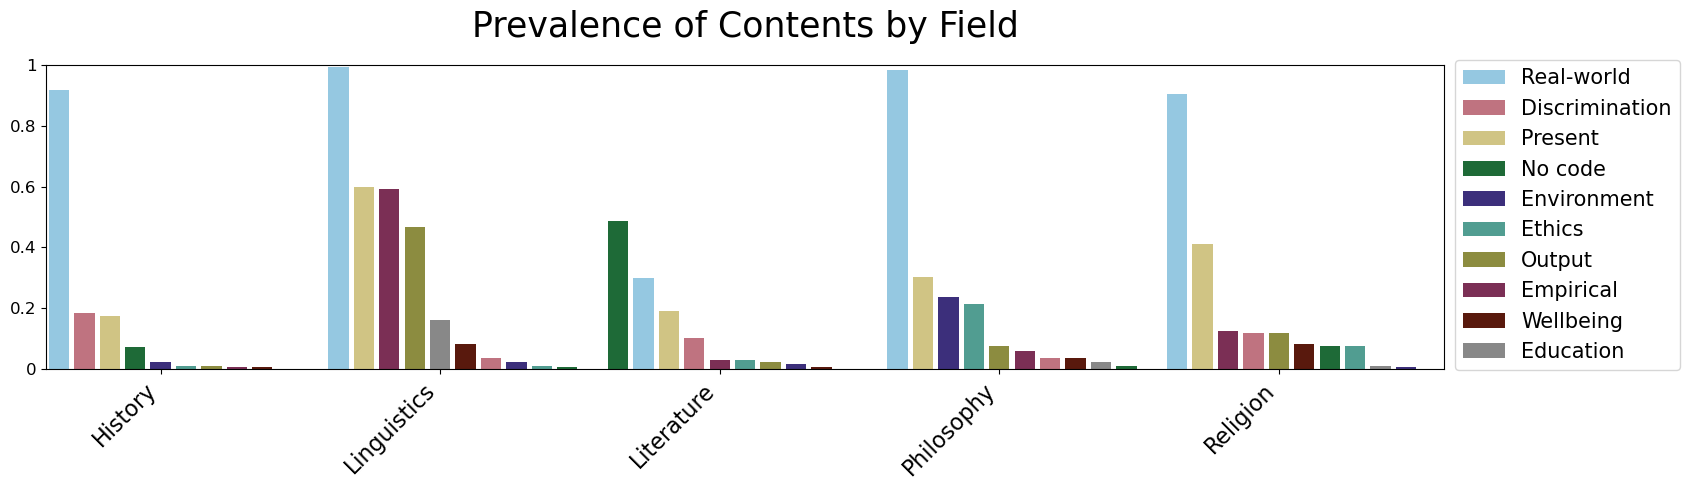

In [62]:
# plot content codes by field

# font size variables
title_fs = 25
label_fs = 19
tick_fs = 16
legend_fs = 15


# make a df with one row per abstract
df_codes = df.drop_duplicates(subset="doi")[content_codes + ["field", "group"]].copy()

# add a column that indicates whether an abstract has no codes at all
df_codes["No code"] = (
    df_codes[content_codes].sum(axis=1).apply(lambda x: 1 if x == 0 else 0)
)
content_codes2 = ["No code"] + content_codes

# get the prevalence data by field
topics_by_field = (
    df_codes.groupby("field")[content_codes2].mean().reset_index().melt(id_vars="field")
)
topics_by_field["variable"] = topics_by_field["variable"].replace(
    {content_codes2[i]: labels[i] for i in range(len(labels))}
)

# Sort data within each field by value
topics_by_field_sorted = topics_by_field.sort_values(
    ["field", "value"], ascending=[True, False]
)

# Create a combined category for sorting within fields
topics_by_field_sorted["field_variable"] = topics_by_field_sorted.apply(
    lambda row: f"{row['field']} - {row['variable']}", axis=1
)

# add an empty column to have whitespace
empty_df = pd.DataFrame(
    {
        i: ["empty", -0.001, f"{i} - empty"]
        for i in topics_by_field_sorted.field.unique()
    }
).T.reset_index()
empty_df.columns = ["field", "variable", "value", "field_variable"]
topics_by_field_sorted = pd.concat([topics_by_field_sorted, empty_df]).sort_values(
    by=["field", "value"], ascending=[True, False]
)

# Convert 'field_variable' to a categorical type with an order based on the sorted data
topics_by_field_sorted["field_variable"] = pd.Categorical(
    topics_by_field_sorted["field_variable"],
    categories=topics_by_field_sorted["field_variable"].unique(),
    ordered=True,
)

# Plot using the sorted 'field_variable' as the x-axis to show individual ordering
fig, ax = plt.subplots(figsize=(17, 5), facecolor="white")

# Create the bar plot
sns.barplot(
    data=topics_by_field_sorted,
    x="field_variable",
    y="value",
    hue="variable",
    dodge=False,
    palette=cat_colors,
    ax=ax,
)

# Customize the x-axis to show field names only once for each group
fields_order = topics_by_field_sorted["field"].unique()
unique_positions = [4, 15, 26, 37, 48]

# Set x-tick labels only at unique positions
ax.set_xticks(unique_positions)
ax.set_xticklabels(fields_order, fontsize=tick_fs, rotation=45, ha="right")

# Set title, labels, and legend
ax.set_ylabel("", fontsize=label_fs)
ax.set_xlabel("", fontsize=label_fs)
ax.set_title("Prevalence of Contents by Field", fontsize=title_fs, pad=20)
# Get current handles and labels
handles, labels = ax.get_legend_handles_labels()

# Exclude the empty item from the legend
ax.legend(
    handles[:-1], labels[:-1], title="", bbox_to_anchor=(1.00, 1.05), fontsize=legend_fs
)

# Set y-tick limits
ax.set_ylim(0, 1)

ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=tick_fs - 4)

# Adjust layout and show
plt.tight_layout()
plt.savefig(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\codes_prevalence.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Figure 7: Abstract characteristics

C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\p

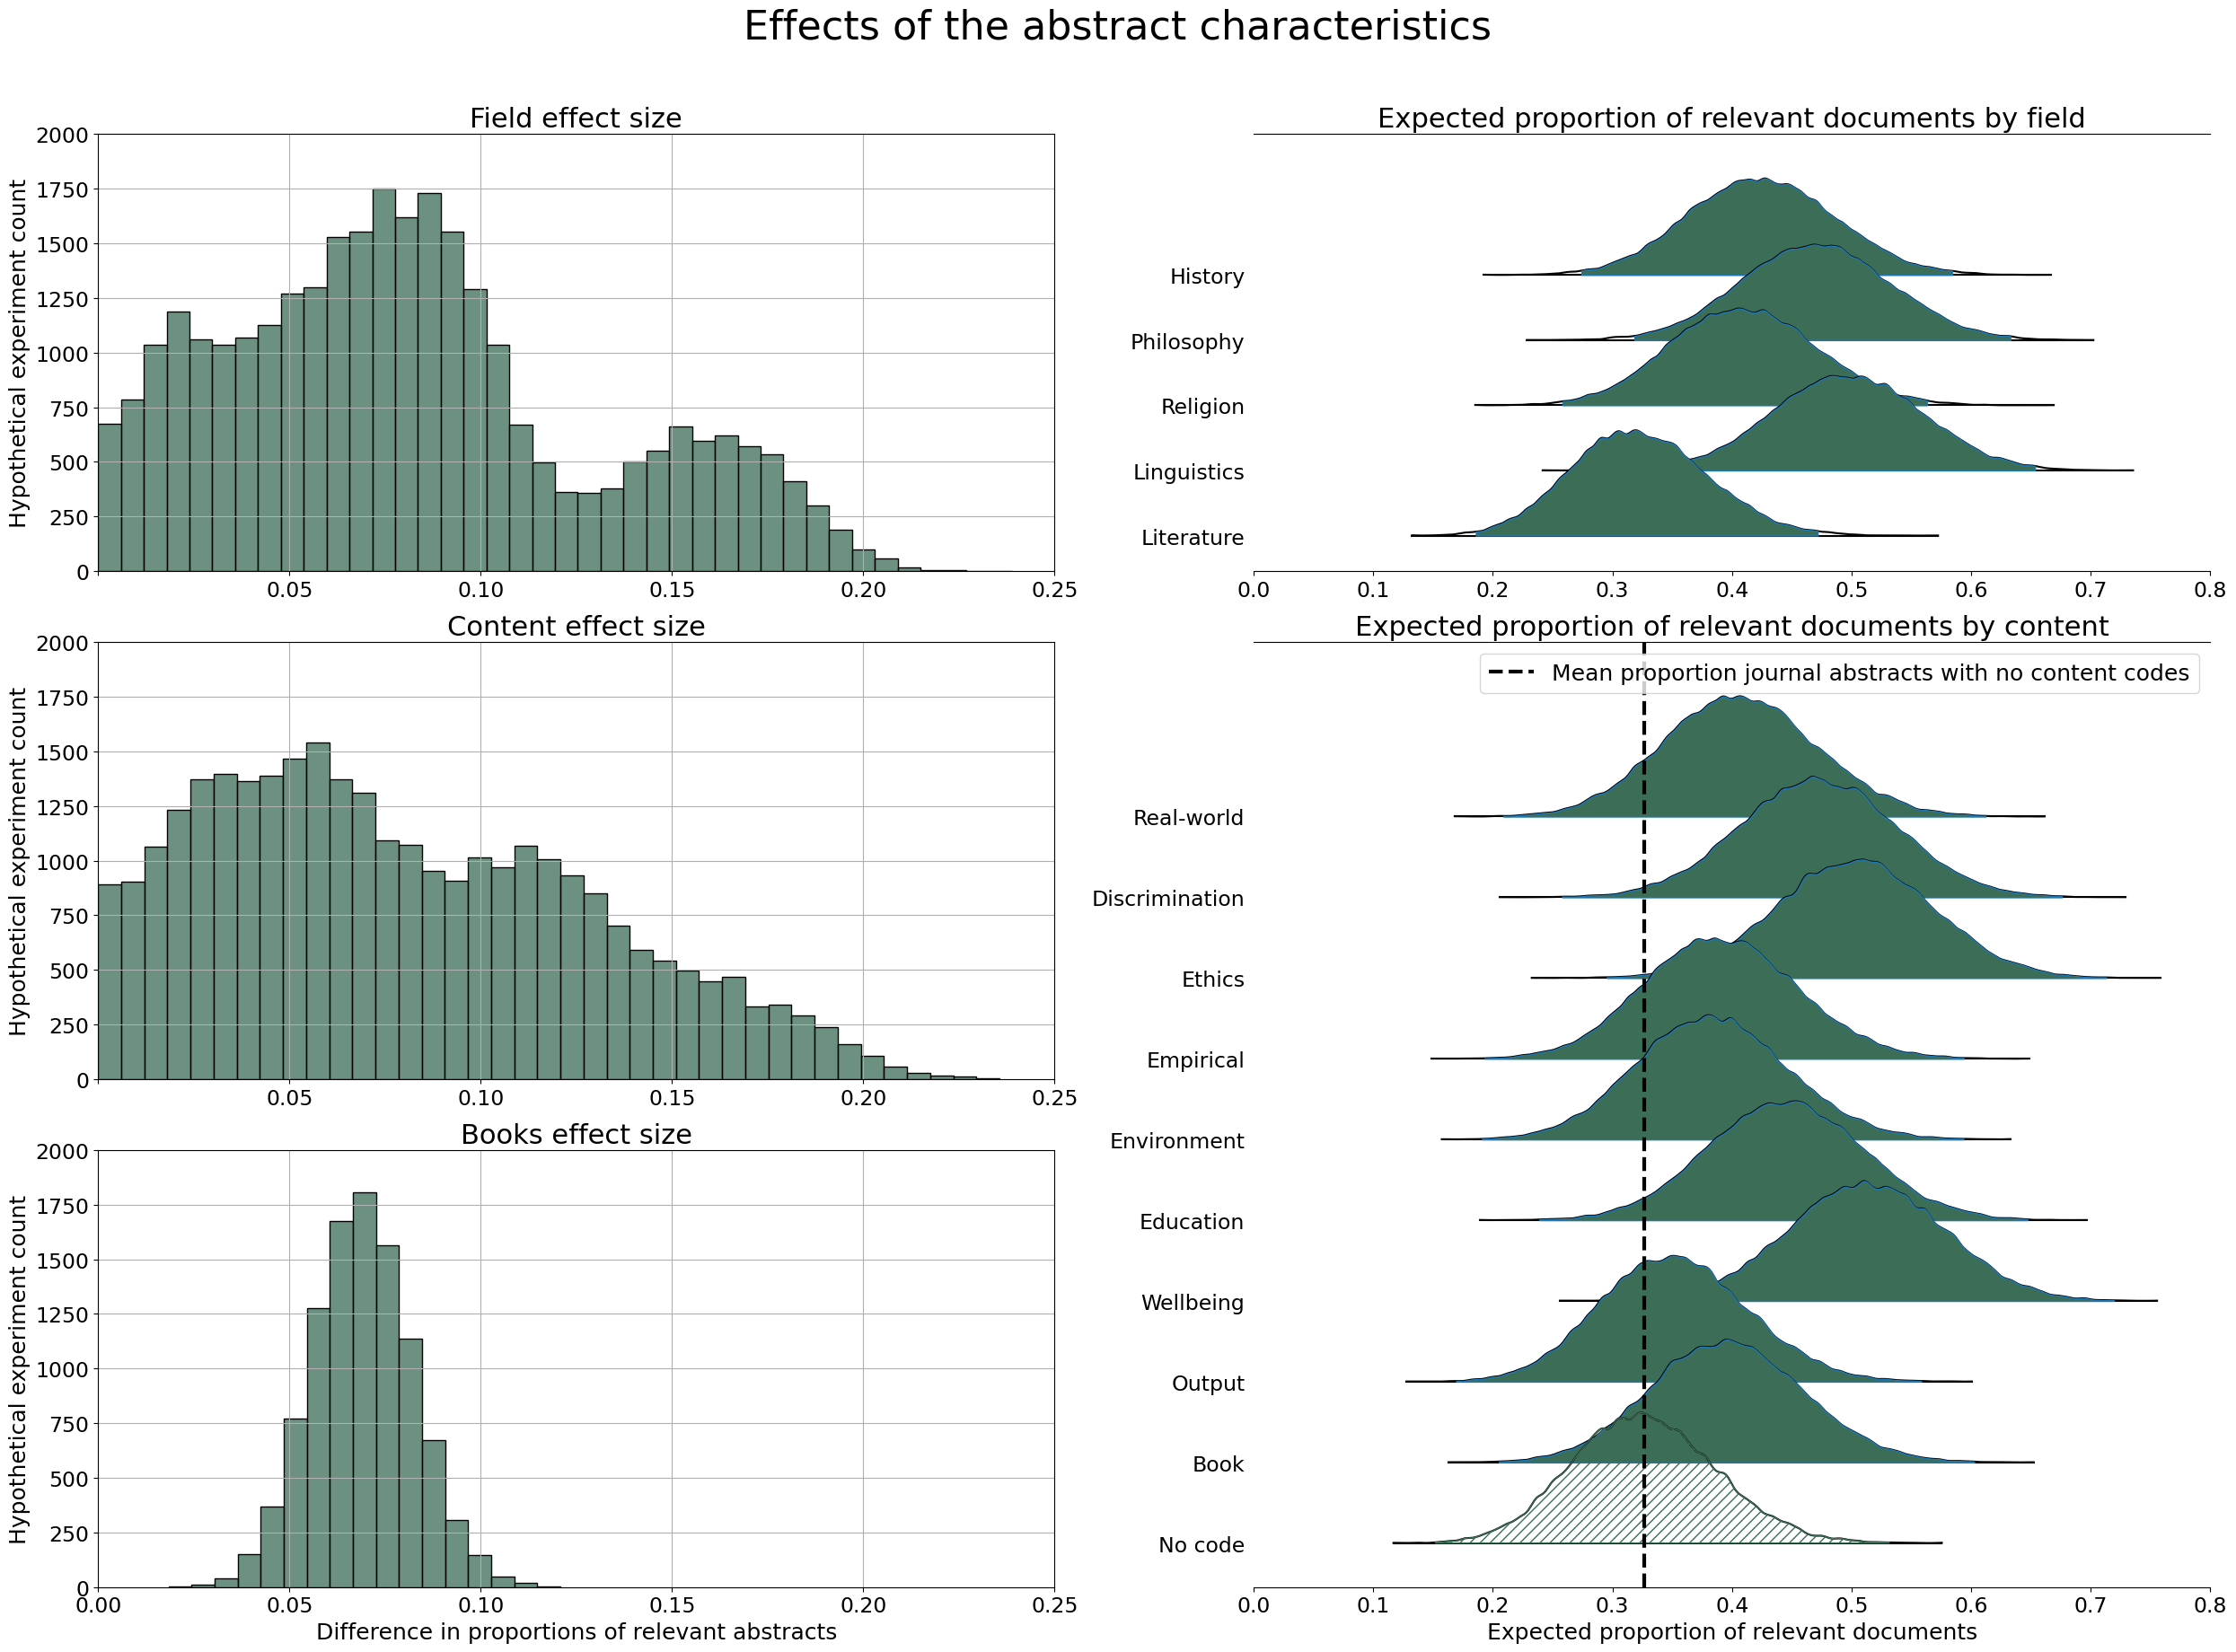

In [63]:
# Make a figure that plots the various document characteristics

n_samples = 30000

# Font size and histogram variables
title_fs = 22
ylabel_fs = 18
label_fs = 28
tick_fs = 17
suptitle_fs = 32
binning_method = "fd"
bin_width = 0.006

# The figure and GridSpec objects
fig = plt.figure(figsize=(25, 18))
gs = GridSpec(6, 6, figure=fig)

# Define axes
ax1 = fig.add_subplot(gs[:2, :3])
ax2 = fig.add_subplot(gs[:2, 3:])
ax3 = fig.add_subplot(gs[2:4, :3])
ax4 = fig.add_subplot(gs[2:, 3:])
ax5 = fig.add_subplot(gs[4:, :3])

# Set uniform limits for the axes
for i in [ax1, ax3, ax5]:
    i.set_xlim(0, 0.25)
    i.set_ylim(0, 2000)

for i in [ax2, ax4]:
    i.set_xlim(0, 0.8)

# grid for all subplots
for i in [ax1, ax2, ax3, ax4, ax5]:
    i.grid(True)

# Plot 1: fields effect size
sns.histplot(
    df_es.es_field.sample(n=n_samples, random_state=2808),
    color=document_color,
    ax=ax1,
    binwidth=bin_width,
    bins=binning_method,
)
ax1.set_title("Field effect size", fontsize=title_fs)
ax1.set_ylabel("Hypothetical experiment count", fontsize=ylabel_fs)
ax1.tick_params(axis="both", which="major", labelsize=tick_fs)
ax1.set_xlabel("")

# Remove redundant tick on the x-axis for plot 1
ax1.xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{x:.2f}" if x != 0 else "")
)

# Plot 2: ridgeplot fields
# use arviz forestplot; for that I need to make the data an inferencedataobject first

shape1, shape2 = fields_array.shape
fields_stacked_array = fields_array.T.reshape((1, shape2, shape1))

datadict = {"fields": fields_stacked_array}
coords = {"field_names": fields_order}
dims = {"fields": ["field_names"]}
fields_dataset = az.convert_to_inference_data(datadict, coords=coords, dims=dims)

az.plot_forest(
    fields_dataset,
    kind="ridgeplot",
    ridgeplot_truncate=False,
    hdi_prob=0.99,
    ridgeplot_alpha=1,
    ridgeplot_overlap=4,
    ax=ax2,
)

labels_fields = [
    "Literature",
    "Linguistics",
    "Religion",
    "Philosophy",
    "History",
]  # this is the reverse order of the fields_array
ax2.set_yticklabels(labels_fields, fontsize=tick_fs)
ax2.set_title("Expected proportion of relevant documents by field", fontsize=title_fs)
ax2.tick_params(axis="both", which="major", labelsize=tick_fs)

for i, poly in enumerate(ax2.collections):
    poly.set_facecolor(document_color)

# Plot 3: topics effect size
sns.histplot(
    df_es.es_content.sample(n=n_samples, random_state=2808),
    ax=ax3,
    color=document_color,
    binwidth=bin_width,
    bins=binning_method,
)
ax3.set_ylabel("Hypothetical experiment count", fontsize=ylabel_fs)
ax3.set_xlabel("", fontsize=ylabel_fs)
ax3.set_title("Content effect size", fontsize=title_fs)
ax3.tick_params(axis="both", which="major", labelsize=tick_fs)

# Remove redundant tick on the x-axis
ax3.xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{x:.2f}" if x != 0 else "")
)

# Plot 4: ridgeplot content

# this is from the contents_array
# I swapped 'Book' and 'No code' because we want No code to be last
content_keys = [
    "fiction",
    "intolerance",
    "ethics",
    "empirical",
    "environment",
    "education",
    "wellbeing",
    "deliverable",
    "Book",
    "No code",
]

labels_content = [
    "Real-world",
    "Discrimination",
    "Ethics",
    "Empirical",
    "Environment",
    "Education",
    "Wellbeing",
    "Output",
    "Book",
    "No code",
]


# Swap the 9th and 10th arrays to put no code last
contents_array_plot = contents_array.copy()
contents_array_plot[[8, 9]] = contents_array_plot[[9, 8]]

shape1, shape2 = contents_array_plot.shape
stacked_contents_array = contents_array_plot.T.reshape((1, shape2, shape1))

datadict = {"content": stacked_contents_array}
coords = {"content_names": content_keys}
dims = {"content": ["content_names"]}
contents_dataset = az.convert_to_inference_data(datadict, coords=coords, dims=dims)

# Add the mean of 'no code', so all density plots can be compared to that easily
ax4.axvline(contents_array_plot[9, :].mean(), ls="--", lw=3, color="black")

# plot the density plots of the topics
az.plot_forest(
    contents_dataset,
    kind="ridgeplot",
    ridgeplot_truncate=False,
    hdi_prob=0.999,
    ridgeplot_alpha=1,
    ridgeplot_overlap=4,
    ax=ax4,
)

# for some reason, labels seem reversed in arviz
# so reverse first
labels_content.reverse()
ax4.set_yticklabels(labels_content, fontsize=tick_fs)
ax4.set_xlabel("Expected proportion of relevant documents", fontsize=ylabel_fs)
ax4.set_title("Expected proportion of relevant documents by content", fontsize=title_fs)
ax4.tick_params(axis="both", which="major", labelsize=tick_fs)
ax4.legend(
    ["Mean proportion journal abstracts with no content codes"], fontsize=ylabel_fs
)


# change the color
for i, poly in enumerate(ax4.collections):
    if i == 0:
        poly.set_facecolor("none")  # Set face color to none
        poly.set_edgecolor(document_color)  # Set the edge color for better visibility
        poly.set_hatch("///")  # Set a hatch pattern for 'no code'
    else:
        poly.set_facecolor([document_color])


# Plot 5: books effect size
sns.histplot(
    np.random.choice(book_es, 10000, replace=False),
    ax=ax5,
    color=document_color,
    binwidth=bin_width,
    bins=binning_method,
)
ax5.set_ylabel("Hypothetical experiment count", fontsize=ylabel_fs)
ax5.set_xlabel("Difference in proportions of relevant abstracts", fontsize=ylabel_fs)
ax5.set_title("Books effect size", fontsize=title_fs)

ax5.tick_params(axis="both", which="major", labelsize=tick_fs)


# overall title and layout
plt.suptitle("Effects of the abstract characteristics", fontsize=suptitle_fs, y=1.02)
fig.tight_layout()

# # # Save the figure
fig.savefig(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\document_effectsizes.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

# Figure 8: Rater characteristics

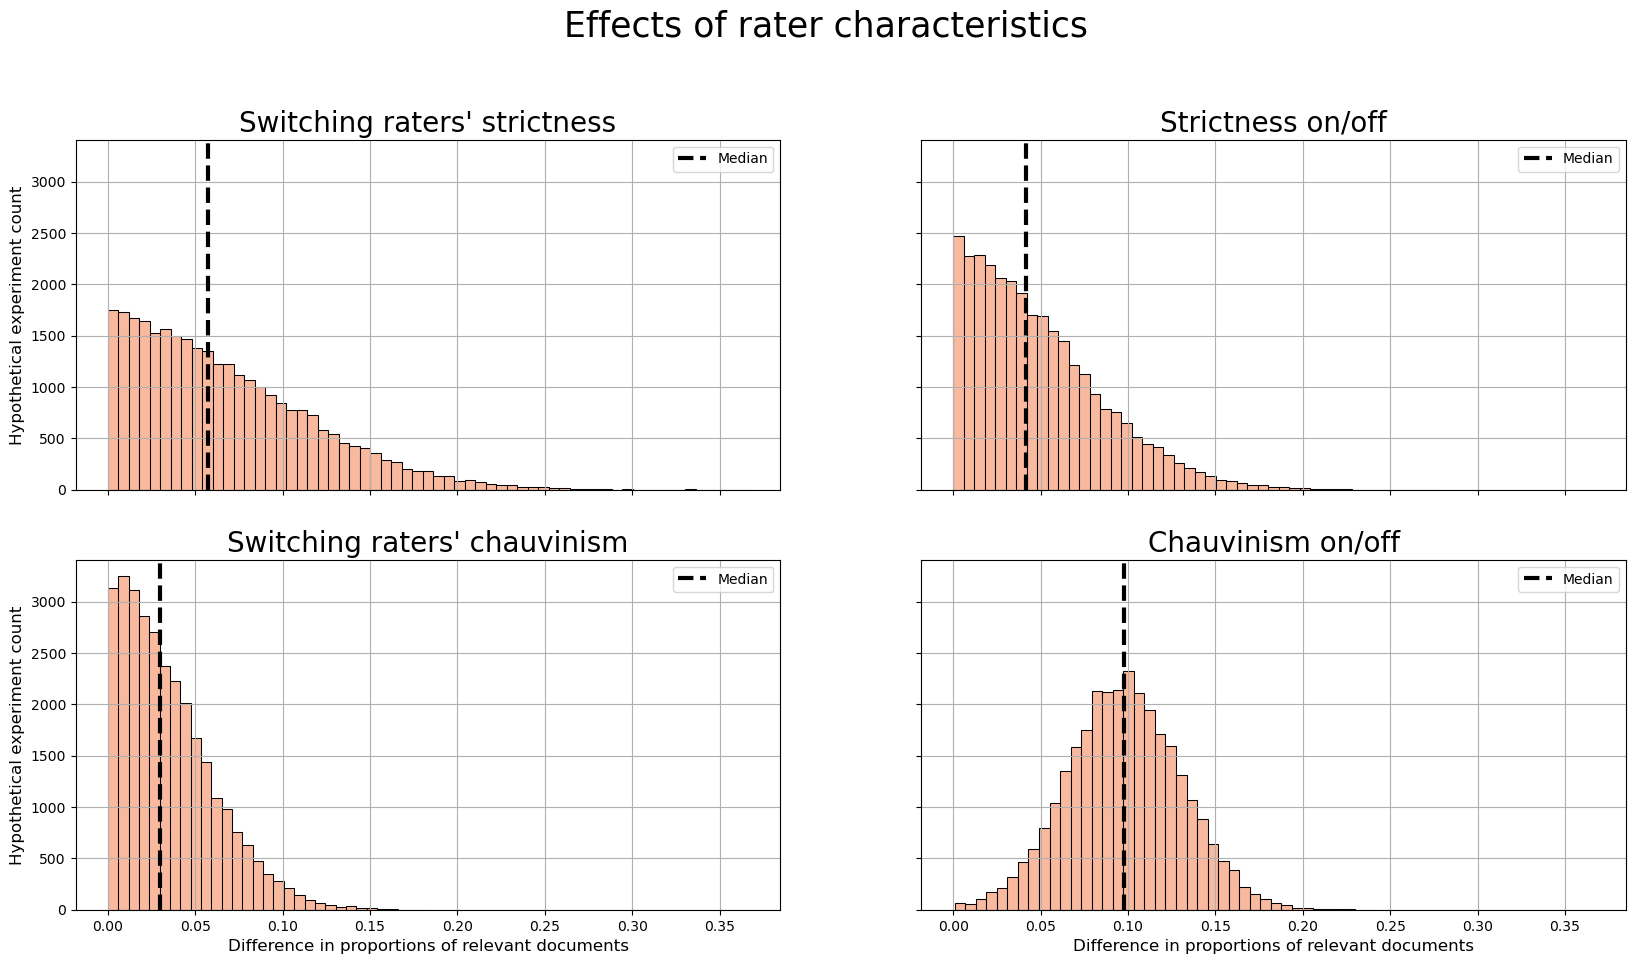

In [64]:
# Make a figure with all rater characteristics

title_fs = 20
label_fs = 12
binning_method = "fd"
bin_width = 0.006

fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharey=True, sharex=True)

# grid for all subplots

for i in ax.flatten():
    i.grid(True)

# plot strictness effect size (switching raters)
sns.histplot(
    df_es.es_strictness,
    ax=ax[0, 0],
    color=rater_color,
    binwidth=bin_width,
    bins=binning_method,
)
ax[0, 0].set_title("Switching raters' strictness", fontsize=title_fs)
ax[0, 0].set_ylabel("Hypothetical experiment count", fontsize=label_fs)

# plot the median
ax[0, 0].axvline(df_es.es_strictness.median(), color="black", lw=3, ls="--")


# plot with and without strictness
sns.histplot(
    df_es.strictness_onoff,
    ax=ax[0, 1],
    color=rater_color,
    binwidth=bin_width,
    bins=binning_method,
)
ax[0, 1].set_title("Strictness on/off", fontsize=title_fs)

# plot the median
ax[0, 1].axvline(df_es.strictness_onoff.median(), color="black", lw=3, ls="--")


# chauvinism effect size
sns.histplot(
    df_es.es_chauvinism,
    ax=ax[1, 0],
    color=rater_color,
    binwidth=bin_width,
    bins=binning_method,
)
ax[1, 0].set_title("Switching raters' chauvinism", fontsize=title_fs)
ax[1, 0].set_ylabel("Hypothetical experiment count", fontsize=label_fs)
ax[1, 0].set_xlabel(
    "Difference in proportions of relevant documents", fontsize=label_fs
)

# plot the median
ax[1, 0].axvline(df_es.es_chauvinism.median(), color="black", lw=3, ls="--")


# chauvinism on off
sns.histplot(
    df_es.chauvinism_onoff,
    ax=ax[1, 1],
    color=rater_color,
    binwidth=bin_width,
    bins=binning_method,
)
ax[1, 1].set_title("Chauvinism on/off", fontsize=title_fs)
ax[1, 1].set_xlabel(
    "Difference in proportions of relevant documents", fontsize=label_fs
)

# plot the median
ax[1, 1].axvline(df_es.chauvinism_onoff.median(), color="black", lw=3, ls="--")

# legend for all
for i in ax.flatten():
    i.legend(["Median"])


plt.suptitle("Effects of rater characteristics", fontsize=25, y=1.01)
fig.savefig(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\rater_effectsizes.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

# Figure 9: Chauvinism by rater

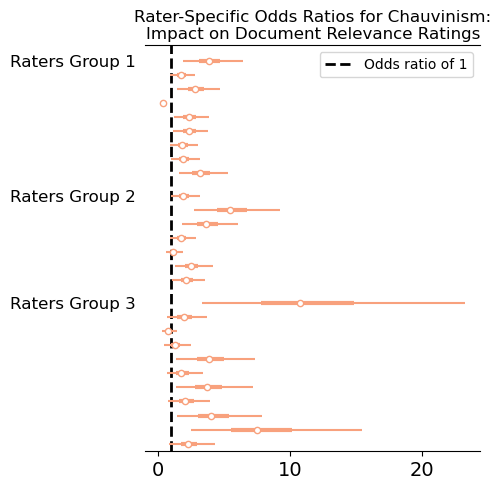

In [65]:
# plot the chauvinism odds ratios for each rater
# plot them by group

fig, ax = plt.subplots(figsize=(5, 5))


# put line at 1 to compare
ax.axvline(1, color="black", ls="--", lw=2)

# make the forest plot
az.plot_forest(
    np.exp(
        trace_chauv_thurstonian_all.posterior[
            ["g1chauvinism", "g2chauvinism", "chauvinism_hum"]
        ]
    ),
    colors=rater_color_hex,
    combined=True,
    ax=ax,
)
ax.set_title(
    "Rater-Specific Odds Ratios for Chauvinism: Impact on Document Relevance Ratings"
)

# legend
ax.legend(["Odds ratio of 1"])

# remove ticks for individual raters
# only indicate groups
custom_yticks = (
    [" " for i in range(10)]
    + ["Raters Group 3"]
    + [" " for i in range(6)]
    + ["Raters Group 2"]
    + [" " for i in range(8)]
    + ["Raters Group 1"]
)
ax.set_yticklabels(custom_yticks, fontsize=12)

# save and show
fig.tight_layout()
fig.savefig(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\paper_figures\chauv_OR.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()